In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
from itertools import product
from functools import reduce

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import entropy, mannwhitneyu, pearsonr, wilcoxon
from sklearn import metrics

from scorer.scorer import Score

## Data preparation

In [3]:
MUST_HAVE_LABELS = ("endemic", "non_case")
DATA_LABELS = ("one", "two", "three") + MUST_HAVE_LABELS

In [4]:
# define coordinate system with two axes x1 and x2
df_coordinates = pd.concat(
    [
        pd.DataFrame(columns=["x1", "x2"], data=product(range(5), range(5))),
        pd.DataFrame(columns=DATA_LABELS),
    ]
)

In [5]:
# read in data
one = [0] * 5 + [0, 1, 1, 0, 0] + [0, 0, 1, 0, 0] + [0] * 10
two = (
    [
        0,
        0,
        1,
        1,
        1,
    ]
    + [0] * 10
    + [0, 0, 0, 1, 0]
    + [0] * 5
)
three = [0] * 15 + [0, 0, 0, 1, 2] + [0] * 5
endemic = (
    [0] * 5 + [1, 0, 0, 0, 0] + [0, 1, 0, 0, 0] + [4, 0, 0, 0, 1] + [2, 0, 0, 0, 1]
)

df_cases = df_coordinates.assign(one=one, two=two, three=three, endemic=endemic)

In [6]:
df_cases.head()

,x1,x2,one,two,three,endemic,non_case
0,0.0,0.0,0,0,0,0,NaN
1,0.0,1.0,0,0,0,0,NaN
2,0.0,2.0,0,1,0,0,NaN
3,0.0,3.0,0,1,0,0,NaN
4,0.0,4.0,0,1,0,0,NaN


## Signal creation

In [7]:
def run_algo_A(df_coordinates):
    assert len(df_coordinates) == 25
    signale = pd.DataFrame(
        {
            "x1": [1, 1, 2, 2, 3, 4],
            "x2": [1, 2, 1, 2, 0, 0],
            "w_A": [1, 1, 1, 1, 0.5, 0.5],
        }
    )
    signale = df_coordinates.loc[:, ["x1", "x2"]].merge(
        signale, how="left", on=["x1", "x2"]
    )
    return signale.fillna(0)


def run_algo_B(df_coordinates):
    assert len(df_coordinates) == 25
    signale = pd.DataFrame(
        {
            "x1": [2, 2, 2, 3, 3, 3, 4, 4, 4],
            "x2": [2, 3, 4, 2, 3, 4, 2, 3, 4],
            "w_B": [0.5] * 9,
        }
    )
    signale = df_coordinates.loc[:, ["x1", "x2"]].merge(
        signale, how="left", on=["x1", "x2"]
    )
    return signale.fillna(0)


def run_algo_C(df_coordinates):
    assert len(df_coordinates) == 25
    signale = pd.DataFrame({"x1": [0], "x2": [4], "w_C": [1]})
    signale = df_coordinates.loc[:, ["x1", "x2"]].merge(
        signale, how="left", on=["x1", "x2"]
    )
    return signale.fillna(0)

In [8]:
# create signals
signal_A = run_algo_A(df_coordinates)
signal_B = run_algo_B(df_coordinates)
signal_C = run_algo_C(df_coordinates)

signals_without_endemic_non_case = reduce(
    lambda l, r: pd.merge(l, r, on=["x1", "x2"]),
    [signal_A, signal_B, signal_C],
)

signals_without_endemic_non_case.head()

,x1,x2,w_A,w_B,w_C
0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,2.0,0.0,0.0,0.0
3,0.0,3.0,0.0,0.0,0.0
4,0.0,4.0,0.0,0.0,1.0


### Calculate signal for endemic and non-case when not given by algo

<AxesSubplot:title={'center':'endemic_mean'}>

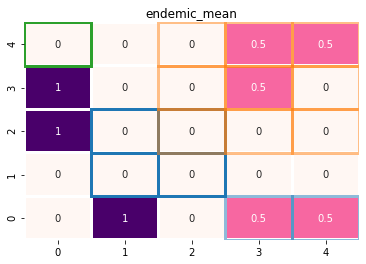

In [9]:
s = Score(
    df_cases,
    signals_without_endemic_non_case,
    ["one", "two", "three"],
    missing_signal_agg="min",
)

s.plot_map(
    s.signals.w_endemic,
    "endemic_mean",
)

## Score calculation (regression)

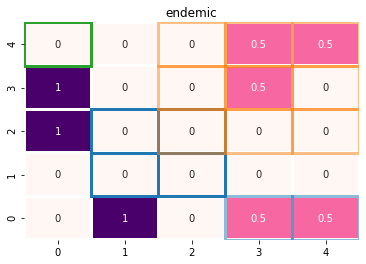

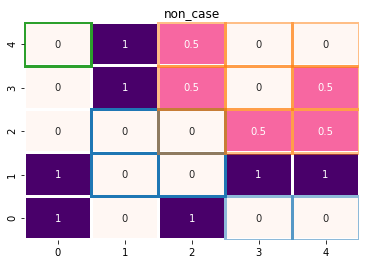

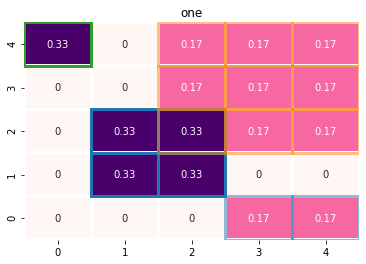

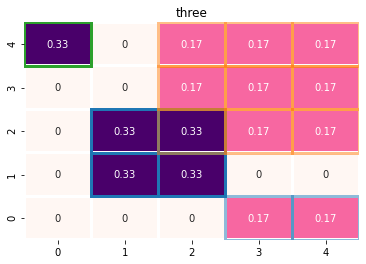

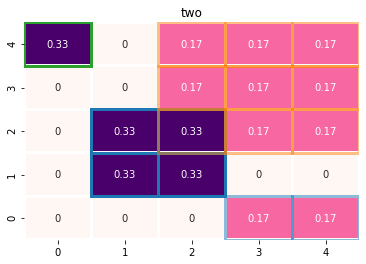

In [10]:
for datalabel in s.p_hat_di().d_i.unique():
    s.plot_map(s.p_hat_di().query("d_i==@datalabel").loc[:, ["p^(d_i)"]], datalabel)
    plt.show()

In [11]:
time = s.timeliness("x2", 5)
time

{'two': 0.6, 'one': 1.0, 'three': 1.0}

In [12]:
def KL(P, Q):
    """Epsilon is used here to avoid conditional code for
    checking that neither P nor Q is equal to 0."""
    epsilon = 0.00001

    P = P + epsilon
    Q = Q + epsilon

    divergence = np.sum(P * np.log(P / Q))
    return divergence


print("KL")
print(KL(s.eval_df()["p(d_i)"].values / 25, s.eval_df()["p^(d_i)"].values / 25))
print("KL form scikitlearn")
print(entropy(s.eval_df()["p(d_i)"].values, s.eval_df()["p^(d_i)"].values + 0.00001))
print("mutual information")
print(
    metrics.mutual_info_score(
        s.eval_df()["p(d_i)"].values, s.eval_df()["p^(d_i)"].values
    )
)
print("regression score")
print(metrics.r2_score(s.eval_df()["p(d_i)"].values, s.eval_df()["p^(d_i)"].values))
print("RMSE")
print(
    np.sqrt(
        np.mean((s.eval_df()["p(d_i)"].values - s.eval_df()["p^(d_i)"].values) ** 2)
    )
)
print("MSE")
print(np.mean((s.eval_df()["p(d_i)"].values - s.eval_df()["p^(d_i)"].values) ** 2))
print("Correlation")
print(pearsonr(s.eval_df()["p(d_i)"].values, s.eval_df()["p^(d_i)"].values))
print("Signed-Wilcoxon")
print(
    wilcoxon(
        s.eval_df()["p(d_i)"].values,
        s.eval_df()["p^(d_i)"].values,
        alternative="two-sided",
    )
)
print("U-test")
print(
    mannwhitneyu(
        s.eval_df()["p(d_i)"].values,
        s.eval_df()["p^(d_i)"].values,
        alternative="two-sided",
    )
)

KL
1.4657710594873727
KL form scikitlearn
1.8546735918556878
mutual information
0.29634980972036773
regression score
0.3965014577259477
RMSE
0.30331501776206204
MSE
0.092
Correlation
(0.6358779630814554, 1.6222647280089715e-15)
Signed-Wilcoxon
WilcoxonResult(statistic=887.5, pvalue=0.8375532487088458)
U-test
MannwhitneyuResult(statistic=6132.5, pvalue=0.0006548121605249147)


### Confusion Matrix

In [13]:
rel_cm = s.multi_conf_mat()

In [14]:
pd.DataFrame(
    {
        "false_pred": [
            rel_cm.loc[
                [c for c in rel_cm.columns if c != "one"],
                [c for c in rel_cm.columns if c != "one"],
            ]
            .sum()
            .sum(),
            rel_cm.loc["one", [c for c in rel_cm.columns if c != "one"]].sum(),
        ],
        "true_pred": [
            rel_cm.loc[[c for c in rel_cm.columns if c != "one"], "one"].sum(),
            rel_cm.loc["one", "one"],
        ],
    },
    index=[
        "false_groundtruth",
        "true_groundtruth",
    ],
)

,false_pred,true_pred
false_groundtruth,19.666667,2.333333
true_groundtruth,2.000000,1.000000


**ENDEMIC**
              precision    recall  f1-score   support

           0       0.94      0.80      0.86        20
           1       0.50      0.80      0.62         5

    accuracy                           0.80        25
   macro avg       0.72      0.80      0.74        25
weighted avg       0.85      0.80      0.81        25

**NON_CASE**
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        12

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25

**ONE**
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        22
           1       0.60      1.00      0.75         3

    accuracy                           0.92        25
   macro avg       0.80      0.95      0.85        25
weighted avg       0.95      0.92      0.

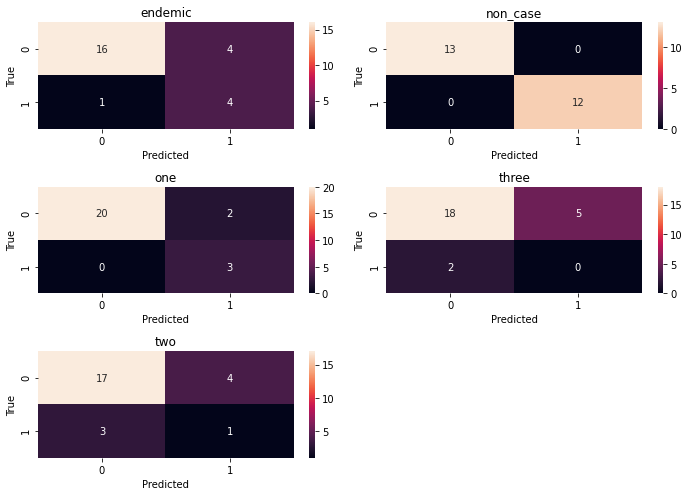

In [15]:
s.class_based_conf_mat()

In [16]:
(
    s.eval_df()
    .assign(
        true=lambda x: np.where(x["p(d_i)"] >= 1 / 3, 1, 0),
        pred=lambda x: np.where(x["p^(d_i)"] >= 1 / 5, 1, 0),
    )
    .pivot(index=["x1", "x2"], columns="d_i", values=["true", "pred"])
).loc[:, (slice(None), "three")]

true  pred
d_i     three three
x1  x2             
0.0 0.0     0     0
    1.0     0     0
    2.0     0     0
    3.0     0     0
    4.0     0     1
1.0 0.0     0     0
    1.0     0     1
    2.0     0     1
    3.0     0     0
    4.0     0     0
2.0 0.0     0     0
    1.0     0     1
    2.0     0     1
    3.0     0     0
    4.0     0     0
3.0 0.0     0     0
    1.0     0     0
    2.0     0     0
    3.0     1     0
    4.0     1     0
4.0 0.0     0     0
    1.0     0     0
    2.0     0     0
    3.0     0     0
    4.0     0     0

**ENDEMIC**
              precision    recall  f1-score   support

           0       0.94      0.80      0.86        20
           1       0.50      0.80      0.62         5

    accuracy                           0.80        25
   macro avg       0.72      0.80      0.74        25
weighted avg       0.85      0.80      0.81        25

**NON_CASE**
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        12

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25

**ONE**
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        22
           1       0.60      1.00      0.75         3

    accuracy                           0.92        25
   macro avg       0.80      0.95      0.85        25
weighted avg       0.95      0.92      0.

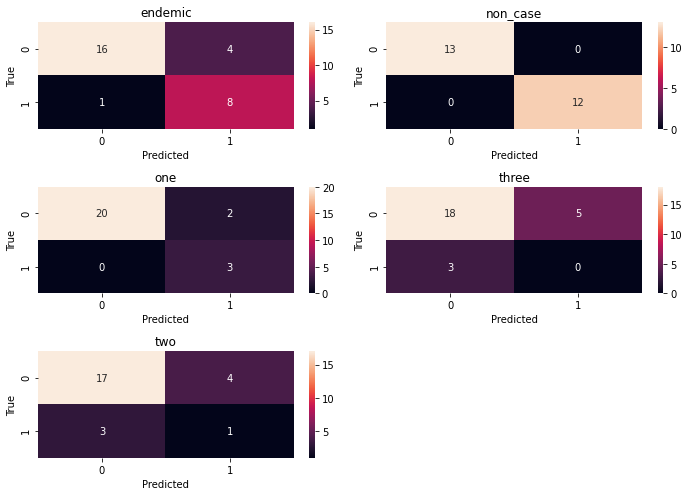

In [17]:
s.class_based_conf_mat(weighted=True)

In [18]:
pt = (
    s.eval_df()
    .assign(
        true=lambda x: np.where(x["p(d_i)"] >= 1 / 3, 1, 0),
        pred=lambda x: np.where(x["p^(d_i)"] >= 1 / 5, 1, 0),
    )
    .pivot(index=["x1", "x2"], columns="d_i", values=["true", "pred"])
)

In [19]:
pt.loc[:, "true"].values

array([[0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 1],
       [1, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0]])

In [21]:
series = (
    s.data.iloc[:, ~s.data.columns.str.contains("x")]
    .where(lambda x: x > 1)
    .sum(axis=1)
    .where(lambda x: x > 0)
    .dropna()
)

In [22]:
for i in series.iteritems():
    print(i)

(15, 4.0)
(19, 2.0)
(20, 2.0)


In [23]:
pt.append(pt.iloc[15])

true                           pred                       
d_i     endemic non_case one three two endemic non_case one three two
x1  x2                                                               
0.0 0.0       0        1   0     0   0       0        1   0     0   0
    1.0       0        1   0     0   0       0        1   0     0   0
    2.0       0        0   0     0   1       1        0   0     0   0
    3.0       0        0   0     0   1       1        0   0     0   0
    4.0       0        0   0     0   1       0        0   1     1   1
1.0 0.0       1        0   0     0   0       1        0   0     0   0
    1.0       0        0   1     0   0       0        0   1     1   1
    2.0       0        0   1     0   0       0        0   1     1   1
    3.0       0        1   0     0   0       0        1   0     0   0
    4.0       0        1   0     0   0       0        1   0     0   0
2.0 0.0       0        1   0     0   0       0        1   0     0   0
    1.0       1        0   0     0   0       0        0   1     1   1
    2.0       0        0   1     0   0       0        0   1     1   1
    3.0       0        1   0     0   0       0        1   0     0   0
    4.0       0        1   0     0   0       0        1   0     0   0
3.0 0.0       1        0   0     0   0       1        0   0     0   0
    1.0       0        1   0     0   0       0        1   0     0   0
    2.0       0        1   0     0   0       0        1   0     0   0
    3.0       0        0   0     1   1       1        0   0     0   0
    4.0       1        0   0     1   0       1        0   0     0   0
4.0 0.0       1        0   0     0   0       1        0   0     0   0
    1.0       0        1   0     0   0       0        1   0     0   0
    2.0       0        1   0     0   0       0        1   0     0   0
    3.0       0        1   0     0   0       0        1   0     0   0
    4.0       1        0   0     0   0       1        0   0     0   0
3.0 0.0       1        0   0     0   0       1        0   0     0   0

In [24]:
pt.loc[:, "true"].values.shape

(25, 5)

In [25]:
s.timeliness("x2", 2)

{'two': 0.0, 'one': 1.0, 'three': 1.0}

### How to score when algo is a classifier
- We look into data distribution and set a cut-off based on data distribution. We assume that the non-outbreak numbers are highest around 0. This peak will flatten when we move away from 0. There we set a cut-off when the next peak is about to start (probably a outbreak cluster)
- Discretize p(d_i) into bins and predict vector of bins
- p(d_i) \element of {0,1} -> confusion matrix

R = [0,1]

B = {0,1}
- p \element R AND p^ \element R -> like the lower, when threshold for p^ is set to e.g., 0.5
- p \element R AND p^ \element B ->
- p \element B AND p^ \element R -> easy/known/ROC/AUC
- p \element B AND p^ \element B -> easy

### References
- KL, Entropy, MI (Wie macht es inhatlich Sinn die Entropie zu berechnen, gegeben den verschiedenen Zellen und DataLabels)
    - Referenz: https://arxiv.org/pdf/1802.03446.pdf
    - Referenz: https://www.sciencedirect.com/science/article/pii/S107731420700077X (pixel-based classifications)
    - Referenz: https://iopscience.iop.org/article/10.1088/1755-1315/47/1/012042/pdf (pixel-based classifications)
    - Likelihood methoden anschauen
    - https://en.wikipedia.org/wiki/Kernel_embedding_of_distributions

## TODO:    
- Geographisches weighting (distanz aller Zell-Kombis spielt eine Rolle)
- statt delays zu addieren, mittelwert der timeliness rechnen
- eventuell kombinieren

## Backlog:
- z-score-based binning (https://core.ac.uk/download/pdf/82692314.pdf)
    - in general quantiles
- attribute cell to data with highest probability
- evt Nouffeily Sim nutzen
- check if score is proper 
- entropy, KL, mutual information probieren abzuleiten und für unseren Fall anzuwenden

## Example scenarios

In [26]:
signal_bad = pd.DataFrame(product(range(5), range(5)), columns=["x1", "x2"]).assign(
    w_A=0, w_B=0, w_C=0
)

score_bad = Score(df_cases, signal_bad, ["one", "two", "three"])

print("R2: ")
print(
    metrics.r2_score(
        score_bad.eval_df()["p(d_i)"].values, score_bad.eval_df()["p^(d_i)"].values
    )
)

R2: 
0.24489795918367363


**ENDEMIC**
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        20
           1       0.38      1.00      0.56         5

    accuracy                           0.68        25
   macro avg       0.69      0.80      0.65        25
weighted avg       0.88      0.68      0.71        25

**NON_CASE**
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        12

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25

**ONE**


C:\Users\AbboodA\AppData\Local\Continuum\miniconda3\envs\scoring\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.88      1.00      0.94        22
           1       0.00      0.00      0.00         3

    accuracy                           0.88        25
   macro avg       0.44      0.50      0.47        25
weighted avg       0.77      0.88      0.82        25

**THREE**
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        23
           1       0.00      0.00      0.00         2

    accuracy                           0.92        25
   macro avg       0.46      0.50      0.48        25
weighted avg       0.85      0.92      0.88        25

**TWO**
              precision    recall  f1-score   support

           0       0.84      1.00      0.91        21
           1       0.00      0.00      0.00         4

    accuracy                           0.84        25
   macro avg       0.42      0.50      0.46        25
weighted avg       0.71      0.84      0.77        25



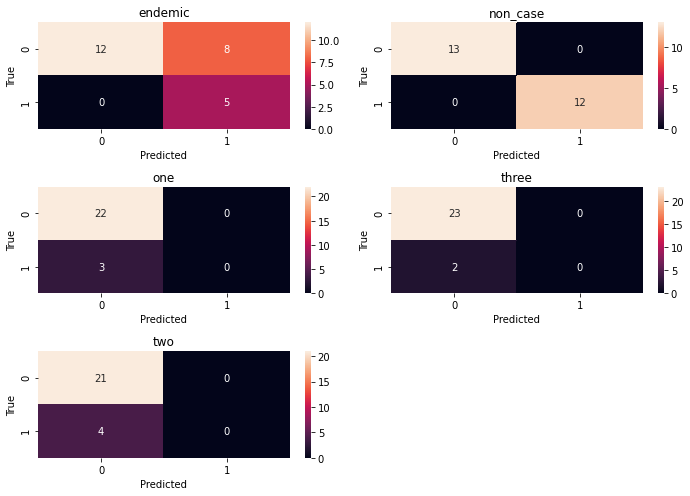

In [27]:
score_bad.class_based_conf_mat()

In [28]:
(
    score_bad.eval_df()
    .assign(
        true=lambda x: np.where(x["p(d_i)"] >= 1 / 3, 1, 0),
        pred=lambda x: np.where(x["p^(d_i)"] >= 1 / 5, 1, 0),
    )
    .pivot(index=["x1", "x2"], columns="d_i", values=["true", "pred"])
).loc[:, "true"]

d_i      endemic  non_case  one  three  two
x1  x2                                     
0.0 0.0        0         1    0      0    0
    1.0        0         1    0      0    0
    2.0        0         0    0      0    1
    3.0        0         0    0      0    1
    4.0        0         0    0      0    1
1.0 0.0        1         0    0      0    0
    1.0        0         0    1      0    0
    2.0        0         0    1      0    0
    3.0        0         1    0      0    0
    4.0        0         1    0      0    0
2.0 0.0        0         1    0      0    0
    1.0        1         0    0      0    0
    2.0        0         0    1      0    0
    3.0        0         1    0      0    0
    4.0        0         1    0      0    0
3.0 0.0        1         0    0      0    0
    1.0        0         1    0      0    0
    2.0        0         1    0      0    0
    3.0        0         0    0      1    1
    4.0        1         0    0      1    0
4.0 0.0        1         0    0      0    0
    1.0        0         1    0      0    0
    2.0        0         1    0      0    0
    3.0        0         1    0      0    0
    4.0        1         0    0      0    0

In [35]:
score_bad.mean_score(metrics.f1_score)

(0.3111111111111111,
 0.5683760683760684,
 0.3123123123123123,
 0.3580246913580247)

In [36]:
signal_sensitive = pd.DataFrame(
    product(range(5), range(5)), columns=["x1", "x2"]
).assign(w_A=1, w_B=1, w_C=1)

score_sensitive = Score(df_cases, signal_sensitive, ["one", "two", "three"])

print("R2: ")
print(
    metrics.r2_score(
        score_sensitive.eval_df()["p(d_i)"].values,
        score_sensitive.eval_df()["p^(d_i)"].values,
    )
)

R2: 
-0.4314868804664722


**ENDEMIC**
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        20
           1       0.00      0.00      0.00         5

    accuracy                           0.80        25
   macro avg       0.40      0.50      0.44        25
weighted avg       0.64      0.80      0.71        25

**NON_CASE**
              precision    recall  f1-score   support

           0       0.52      1.00      0.68        13
           1       0.00      0.00      0.00        12

    accuracy                           0.52        25
   macro avg       0.26      0.50      0.34        25
weighted avg       0.27      0.52      0.36        25



C:\Users\AbboodA\AppData\Local\Continuum\miniconda3\envs\scoring\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**ONE**
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.12      1.00      0.21         3

    accuracy                           0.12        25
   macro avg       0.06      0.50      0.11        25
weighted avg       0.01      0.12      0.03        25

**THREE**
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.08      1.00      0.15         2

    accuracy                           0.08        25
   macro avg       0.04      0.50      0.07        25
weighted avg       0.01      0.08      0.01        25

**TWO**
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.16      1.00      0.28         4

    accuracy                           0.16        25
   macro avg       0.08      0.50      0.14        25
weighted avg       0.03      0.16      0.04     

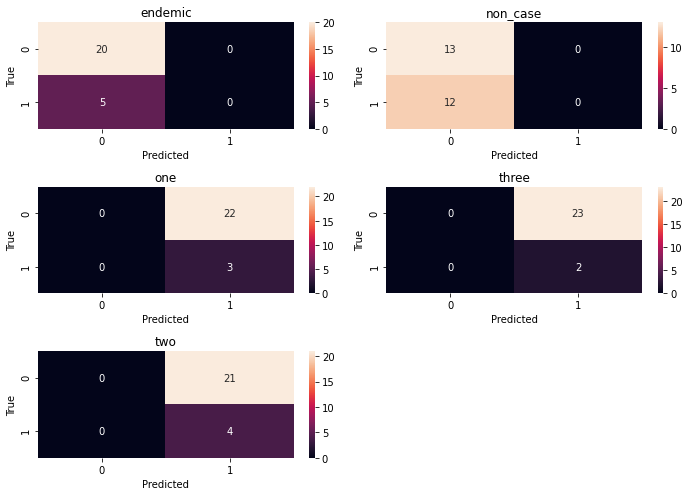

In [37]:
score_sensitive.class_based_conf_mat()

In [40]:
score_sensitive.mean_score(metrics.f1_score)

(0.12765918627987594,
 0.07856160442367341,
 0.11551946034704655,
 0.08738267550528087)

In [41]:
# Nicht blind one, two, three einfügen, sondern nur, wenn die adas Label >0
signal_ideal_df = df_cases.assign(
    w_A=lambda x: np.where(x.endemic == 0, x.one, x.one / (x.one + x.endemic)),
    w_B=lambda x: np.where(x.endemic == 0, x.two, x.two / (x.two + x.endemic)),
    w_C=lambda x: np.where(x.endemic == 0, x.three, x.three / (x.three + x.endemic)),
).drop(["one", "two", "three", "endemic", "non_case"], axis=1)

signal_ideal = Score(
    df_cases, signal_ideal_df, ["one", "two", "three"], missing_signal_agg="min"
)

print("R2: ")
print(
    metrics.r2_score(
        signal_ideal.eval_df()["p(d_i)"].values,
        signal_ideal.eval_df()["p^(d_i)"].values,
    )
)

R2: 
0.7657920310981536


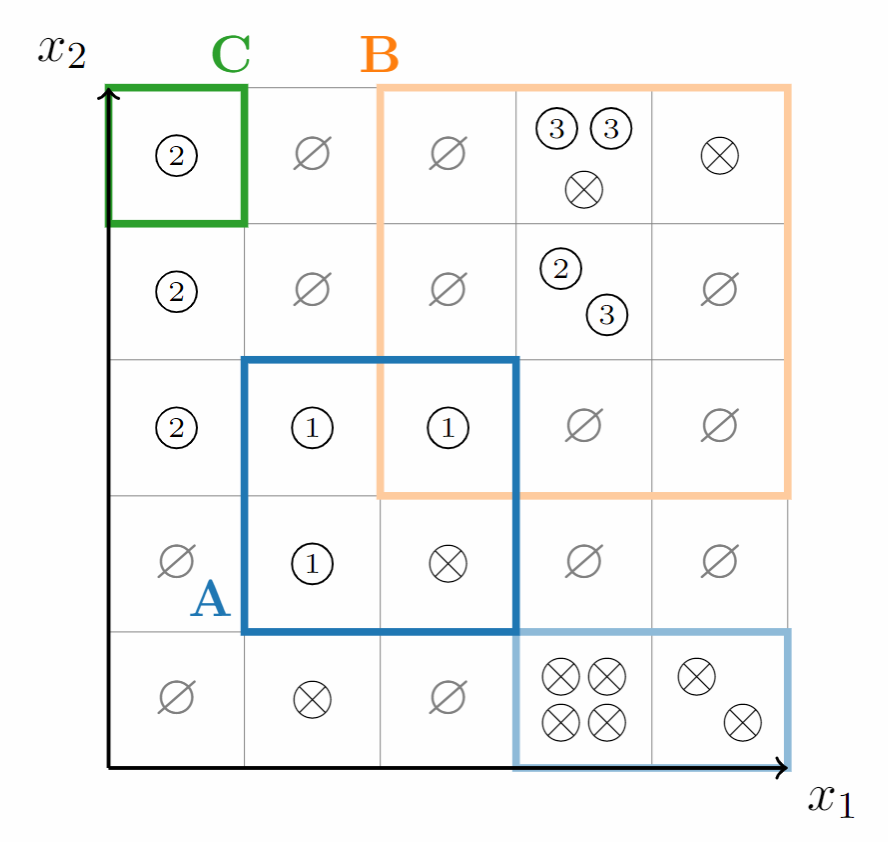

In [88]:
from IPython.display import Image

Image(filename="base.png", width=400, height=400)

**ENDEMIC**
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.83      1.00      0.91         5

    accuracy                           0.96        25
   macro avg       0.92      0.97      0.94        25
weighted avg       0.97      0.96      0.96        25

**NON_CASE**
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        12

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25

**ONE**
              precision    recall  f1-score   support

           0       1.00      0.77      0.87        22
           1       0.38      1.00      0.55         3

    accuracy                           0.80        25
   macro avg       0.69      0.89      0.71        25
weighted avg       0.93      0.80      0.

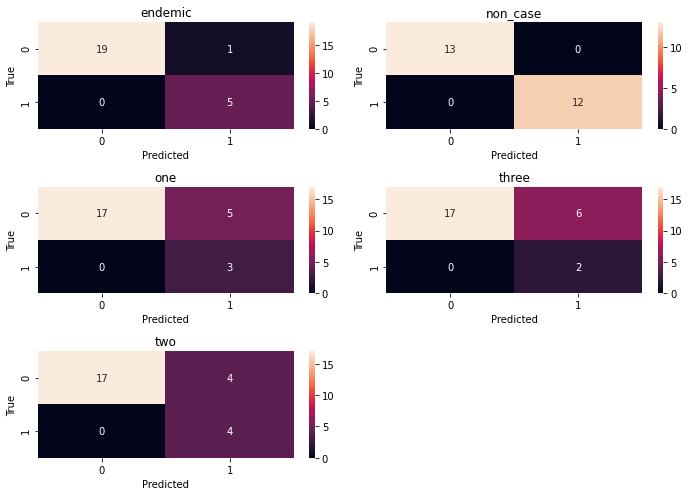

In [42]:
signal_ideal.class_based_conf_mat()

In [44]:
signal_ideal.mean_score(metrics.f1_score)

(0.7042424242424242,
 0.8326340326340328,
 0.7017199017199016,
 0.7387205387205387)

In [45]:
df_cases_1 = df_cases.drop(columns=["two", "three"])

In [46]:
signal_specific_1 = df_cases.assign(
    w_A=lambda x: np.where(x.endemic == 0, x.one, x.one / (x.one + x.endemic)),
).drop(["one", "two", "three", "endemic", "non_case"], axis=1)

score_specific_1 = Score(
    df_cases_1,
    signal_specific_1,
    [
        "one",
    ],
    missing_signal_agg="min",
)

print("R2: ")
print(
    metrics.r2_score(
        score_specific_1.eval_df()["p(d_i)"].values,
        score_specific_1.eval_df()["p^(d_i)"].values,
    )
)

R2: 
1.0


**ENDEMIC**
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00         6

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25

**NON_CASE**
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        16

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25

**ONE**
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00         3

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.

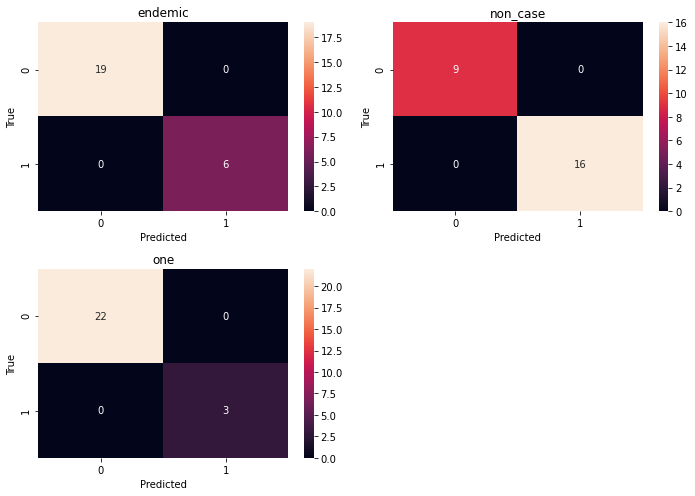

In [47]:
score_specific_1.class_based_conf_mat()

In [48]:
score_specific_1.mean_score(metrics.f1_score)

(1.0, 1.0, 1.0, 1.0)

In [40]:
from scipy.stats import entropy

In [41]:
print("entropy: ")
print(
    entropy(
        score_specific_1.eval_df()["p(d_i)"].values,
        score_specific_1.eval_df()["p^(d_i)"].values,
    )
)

entropy: 
0.0


In [42]:
0.6365141682948126 / np.log(2)

0.9182958340544891

In [49]:
scores = []
for i in range(100):
    signal_specific_random = df_cases.assign(
        w_A=lambda x: np.random.rand(25),
    ).drop(["one", "two", "three", "endemic", "non_case"], axis=1)

    score_specific_random = Score(
        df_cases_1,
        signal_specific_random,
        [
            "one",
        ],
        missing_signal_agg="min",
    )

    scores.append(
        metrics.mutual_info_score(
            score_specific_random.eval_df()["p(d_i)"].values,
            score_specific_random.eval_df()["p^(d_i)"].values,
        )
    )

In [50]:
score_specific_random.mean_score(metrics.f1_score)

(0.55438127090301, 0.6662849498327759, 0.5934448160535115, 0.6618060200668895)

In [44]:
np.mean(scores)

0.6365141682948123

In [45]:
np.std(scores)

7.850462293418876e-17

In [62]:
np.average([5, 7, 2], weights=[1, 2, 3])

4.166666666666667

In [64]:
(5 + 14 + 6) / 6

4.166666666666667

In [55]:
(
    (
        score_specific_random.eval_df()
        .assign(
            true=lambda x: np.where(x["p(d_i)"] >= 1 / 3, 1, 0),
            pred=lambda x: np.where(x["p^(d_i)"] >= 1 / 5, 1, 0),
        )
        .pivot(index=["x1", "x2"], columns="d_i", values=["true", "pred"])
    )
    .loc[:, "true"]
    .sum()
).values

array([ 6, 16,  3], dtype=int64)

In [53]:
(
    score_specific_random.eval_df()
    .assign(
        true=lambda x: np.where(x["p(d_i)"] >= 1 / 3, 1, 0),
        pred=lambda x: np.where(x["p^(d_i)"] >= 1 / 5, 1, 0),
    )
    .pivot(index=["x1", "x2"], columns="d_i", values=["true", "pred"])
    .columns.levels[1]
)

Index(['endemic', 'non_case', 'one'], dtype='object', name='d_i')